In [24]:
from manifold_learning import CCM
from manifold_learning.utils import utils
import importlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.integrate import solve_ivp
importlib.reload(CCM)
importlib.reload(utils)
import time

In [25]:
import torch
torch.cuda.empty_cache()

In [2]:
def lorenz(t, state, sigma, beta, rho):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

In [3]:
def get_lorenz_rand(tmax = 140, n_steps = 10000, sigma=10, beta=8/3, rho=28):
    initial_state = np.random.normal(size=(3))

    trunc = int(n_steps/tmax * 40) # Number of steps to get independence from initial conditions
    t_eval = np.linspace(0, tmax, trunc + n_steps)

    solution = solve_ivp(lorenz, (0, tmax), initial_state, args=(sigma, beta, rho), t_eval=t_eval).y.T[trunc:]
    return solution

In [31]:
X_emb = np.transpose(utils.get_td_embedding_np(get_lorenz_rand(280,n_steps=30000),5,20,return_pred=False),axes=(2,0,1))

In [39]:
X_emb = np.concatenate([np.transpose(utils.get_td_embedding_np(get_lorenz_rand(280,n_steps=30000),4,20,return_pred=False),axes=(2,0,1)) for i in range(10)])
X_emb.shape

(30, 29940, 4)

In [40]:
ccm = CCM.CCM(device="cpu")

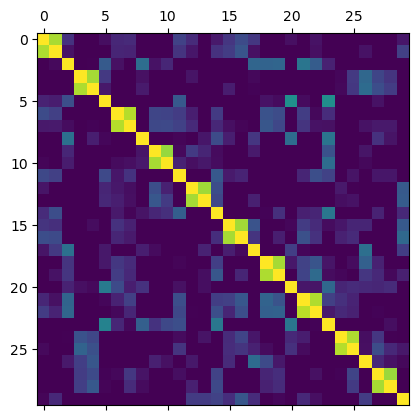

In [41]:
plt.matshow(ccm.get_matrix(X_emb,1000,200,40,10,1)[-1],vmax=1,vmin=0)

In [42]:
%%timeit
ccm.get_matrix(X_emb,1000,200,40,10,1)[-1]

23.3 ms ± 517 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
